# Classification

## Objectives
- Fit and evaluate a classification model to predict if patient will be affected or not by heart disease or not

## Inputs
- outputs/datasets/collection/heart.csv

## Outputs
- Train set (features and target)
- Test set (features and target)
- Data cleaning and Feature Engineering pipeline
- Modeling pipelineFeature importance plot

---




## Setting working Directory
The steps below allow to set heart_attack risk as the new working directory

- get current directory and print it


In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heart_attack_risk/jupyer_notebooks'

- set new working directory as parent of the previous current directory
- As a result heart_attack_risk is the new working directory  

In [3]:
os.chdir(os.path.dirname(current_dir))


---

## Load data

In [4]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/heart.csv"))
df.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


## Data cleaning and Feature Engineering

In [5]:
import numpy as np
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import RandomSampleImputer
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import Pipeline




def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ('RandomSampleImputer', RandomSampleImputer(random_state=42, variables=['Cholesterol'])),
        ('OrdinalCategoricalEncoder', OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Sex', 'ChestPainType', 'RestingECG',
                                                                'ExerciseAngina', 'ST_Slope'])),
        ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                       variables=['Age', 'RestingBP', 'Cholesterol', 'Oldpeak']))
    ])
    
    return pipeline_base

PipelineDataCleaningAndFeatureEngineering()


Pipeline(steps=[('RandomSampleImputer',
                 RandomSampleImputer(random_state=42,
                                     variables=['Cholesterol'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Sex', 'ChestPainType', 'RestingECG',
                                           'ExerciseAngina', 'ST_Slope'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Age', 'RestingBP', 'Cholesterol',
                                       'Oldpeak']))])

## Pipeline for Modelling and Hyperparameter Optimisation

In [6]:
# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

Custom Class for Hyperparameter Optimisation



In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

In Cholesterol feature I substitute 0 with Na to allow data cleaning pipeline

In [8]:
df["Cholesterol"] = df["Cholesterol"].replace(0, np.nan)

## Split Train and Test Set

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['HeartDisease'], axis=1),
    df['HeartDisease'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


## Handle Target Imbalance


In [10]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


Check Train Set Target distribution



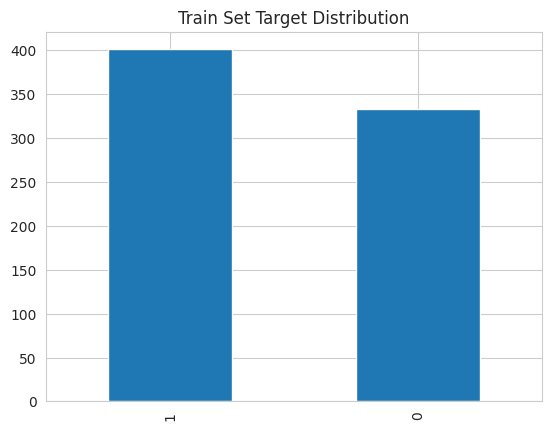

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

No imbalance observed in target feature

## Grid Search CV - Sklearn
### Use standard hyperparameters to find most suitable algorithm

Note: XGB boost was included in the list of classifier, however it was selected as one of the best and due to the library size deployment on cloud was not possible. Therefore, I removed XGB boost from the list of classifiers

In [12]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Quick GridSearch CV - Binary Classifier



In [13]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits



Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/workspace/Heart_attack_risk/heart_attack/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecat

Check results



In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score
0,LogisticRegression,0.825,0.862685,0.925926,0.035683
3,GradientBoostingClassifier,0.825,0.855278,0.888889,0.026093
2,RandomForestClassifier,0.777778,0.843056,0.9,0.042145
4,ExtraTreesClassifier,0.775,0.800463,0.85,0.028722
5,AdaBoostClassifier,0.7125,0.758056,0.8375,0.045367
1,DecisionTreeClassifier,0.703704,0.743241,0.7625,0.02453


### Extensive search on the most suitable algorithm to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [15]:
models_search = {
    "LogisticRegression":LogisticRegression(random_state=0),
}
params_search = {
    "LogisticRegression":{
         'model__C': [0.1, 1, 10],
        'model__penalty': ['l2'],
        'model__solver': ['liblinear', 'lbfgs', 'saga'],
        'model__class_weight': [None, 'balanced']
    }
}

Extensive GridSearch CV - Binary Classifier

In [16]:
from sklearn.metrics import recall_score, make_scorer
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Check results



In [17]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__C,model__class_weight,model__penalty,model__solver
2,LogisticRegression,0.825,0.865216,0.91358,0.029295,0.1,None,l2,saga
1,LogisticRegression,0.825,0.865216,0.91358,0.029295,0.1,None,l2,lbfgs
12,LogisticRegression,0.825,0.862685,0.925926,0.035683,10,None,l2,liblinear
7,LogisticRegression,0.825,0.862685,0.925926,0.035683,1,None,l2,lbfgs
8,LogisticRegression,0.825,0.862685,0.925926,0.035683,1,None,l2,saga
14,LogisticRegression,0.825,0.862685,0.925926,0.035683,10,None,l2,saga
13,LogisticRegression,0.825,0.862685,0.925926,0.035683,10,None,l2,lbfgs
0,LogisticRegression,0.825,0.860247,0.901235,0.025884,0.1,None,l2,liblinear
6,LogisticRegression,0.825,0.860216,0.91358,0.031391,1,None,l2,liblinear
5,LogisticRegression,0.8125,0.845278,0.888889,0.027366,0.1,balanced,l2,saga


Get best model name programmatically

In [18]:
best_model = grid_search_summary.iloc[0,0]
best_model

'LogisticRegression'

Parameters for best model

In [19]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__C': 0.1,
 'model__class_weight': None,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}

Define the best clf pipeline



In [20]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=LogisticRegression(random_state=0))),
                ('model', LogisticRegression(C=0.1, random_state=0))])

## Assess feature importance

In [21]:
X_train.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
378,70.0,0,0,140,177.0,1,0,157,0,2.0,0
356,46.0,0,0,115,274.0,0,0,113,0,1.5,0
738,65.0,1,1,160,360.0,0,1,151,1,0.8,1


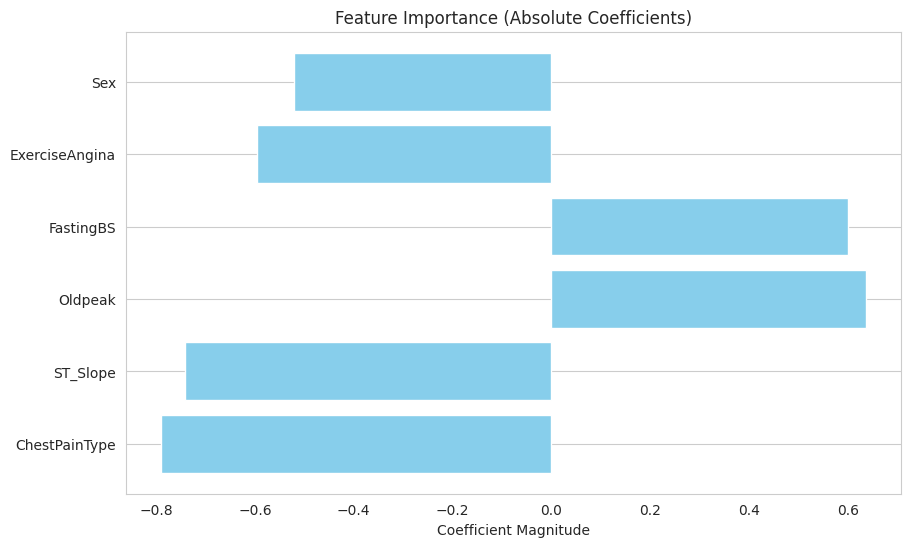

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pipeline_clf is your trained pipeline and X_train is your feature data
# Replace 'pipeline_clf' and 'X_train' with your actual trained pipeline and feature data

# Get the coefficients from the model
coefficients = pipeline_clf['model'].coef_[0]

# Get the feature names from the feature selection step
best_features = X_train.columns[pipeline_clf['feat_selection'].get_support()]

# Create a DataFrame to hold feature names and coefficients
df_coefficients = pd.DataFrame({'Feature': best_features, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitudes
df_coefficients_sorted = df_coefficients.reindex(df_coefficients['Coefficient'].abs().sort_values(ascending=False).index)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_coefficients_sorted['Feature'], df_coefficients_sorted['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance (Absolute Coefficients)')
plt.grid(axis='x')
plt.show()


### Evaluate Pipeline on Train and Test Sets

In [23]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

Assessing Pipeline performances

In [24]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Heart Disease', ' No Heart Disease'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                             Actual Heart Disease Actual  No Heart Disease
Prediction Heart Disease                      274                       53
Prediction  No Heart Disease                   59                      348


---  Classification Report  ---
                   precision    recall  f1-score   support

    Heart Disease       0.84      0.82      0.83       333
 No Heart Disease       0.86      0.87      0.86       401

         accuracy                           0.85       734
        macro avg       0.85      0.85      0.85       734
     weighted avg       0.85      0.85      0.85       734
 

#### Test Set ####

---  Confusion Matrix  ---
                             Actual Heart Disease Actual  No Heart Disease
Prediction Heart Disease                       58                       13
Prediction  No Heart Disease                   19                       94


---  Classification Report  ---
                   precisio

- Precison and Recall for Train set are > 80 %
- For the Test set Precision is > 80% but recall is 75 %
- The pipeline already meets the business requirements of having a precision > 80 %

## Refit pipeline with best features

- Creating a new pipeline with only the most important features 
- The new pipeline checks if the practitioner can predict heart disease with the same precision but using less inputs

In [25]:
best_features = best_features.to_list()
best_features

['Sex', 'ChestPainType', 'FastingBS', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

Best feature pipeline data cleaning and feature engineering

In [26]:
def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['Sex', 'ChestPainType', 'ExerciseAngina', 'ST_Slope'])),
        ('winsorizer_iqr', Winsorizer(capping_method='iqr', fold=1.5, tail='both', 
                                       variables=['Oldpeak']))

    ])

    return pipeline_base

## Rewrite ML Pipeline for Modelling

Pipeline optmisation



In [27]:
# Pipeline Optmization: Model
def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        # no feature selection needed anymore!!! We know which features to use already!
        ("model", model),
    ])

    return pipeline_base

Split Train Test Set best features only

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['HeartDisease'], axis=1),
    df['HeartDisease'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


filter only the most important variables

In [29]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(734, 6) (734,) (184, 6) (184,)


,Sex,ChestPainType,FastingBS,ExerciseAngina,Oldpeak,ST_Slope
378,M,ASY,1,Y,2.0,Flat
356,M,ASY,0,Y,1.5,Flat
738,F,NAP,0,N,0.8,Up


In [30]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 6) (734,) (184, 6) (184,)


## Grid Search CV: Sklearn

Using the same model logist regression

In [31]:
models_search 

{'LogisticRegression': LogisticRegression(random_state=0)}

Using the same parameters

In [32]:
best_parameters

{'model__C': 0.1,
 'model__class_weight': None,
 'model__penalty': 'l2',
 'model__solver': 'lbfgs'}

In [33]:
params_search = {'LogisticRegression':{
 'model__C': [0.1],
 'model__class_weight': [None],
 'model__penalty': ['l2'],
 'model__solver': ['lbfgs']}
 }

params_search

{'LogisticRegression': {'model__C': [0.1],
  'model__class_weight': [None],
  'model__penalty': ['l2'],
  'model__solver': ['lbfgs']}}

GridSearch CV

In [34]:
from sklearn.metrics import recall_score, make_scorer
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Results

In [35]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__C,model__class_weight,model__penalty,model__solver
0,LogisticRegression,0.825,0.870216,0.91358,0.030513,0.1,None,l2,lbfgs


Define the best clf pipeline

In [36]:
best_model = grid_search_summary.iloc[0, 0]
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.1, random_state=0))])

## Evaluate pipeline performace

In [37]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=pipeline_clf,
                label_map= ['Heart disease', 'No heart disease'] 
                )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual Heart disease Actual No heart disease
Prediction Heart disease                     274                      53
Prediction No heart disease                   59                     348


---  Classification Report  ---
                  precision    recall  f1-score   support

   Heart disease       0.84      0.82      0.83       333
No heart disease       0.86      0.87      0.86       401

        accuracy                           0.85       734
       macro avg       0.85      0.85      0.85       734
    weighted avg       0.85      0.85      0.85       734
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual Heart disease Actual No heart disease
Prediction Heart disease                      58                      13
Prediction No heart disease                   19                      94


---  Classification Report  ---
                  precision    recall  f1-sco

Save version

In [38]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_heart_disease/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

[Errno 17] File exists: 'outputs/ml_pipeline/predict_heart_disease/v1'


Save train set

In [39]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [40]:

y_train.to_csv(f"{file_path}/y_train.csv", index=False)

Save test set

In [41]:

X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [42]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

Save pipelines

In [43]:
pipeline_data_cleaning_feat_eng

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Sex', 'ChestPainType',
                                           'ExerciseAngina', 'ST_Slope'])),
                ('winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables=['Oldpeak']))])

In [44]:
joblib.dump(value=pipeline_data_cleaning_feat_eng ,
            filename=f"{file_path}/clf_pipeline_data_cleaning_feat_eng.pkl")

['outputs/ml_pipeline/predict_heart_disease/v1/clf_pipeline_data_cleaning_feat_eng.pkl']